ERN values file not found for sub-IN05ED23
Pearson r (ERN vs PSWQ) = -0.204 for 155 subjects


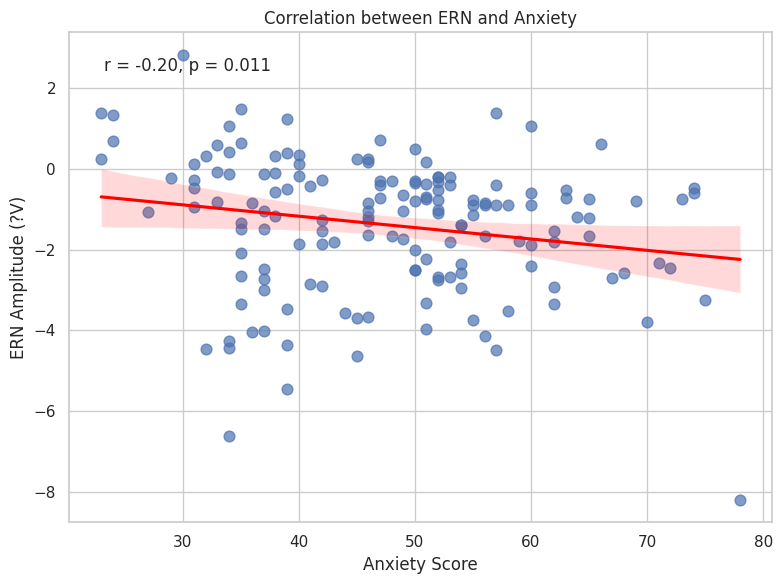

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr

###### Project root directory
project_root = Path("YOUR_PROJECT_ROOT_HERE")  # Replace with your actual project root path

###### Where the ERN .tsv files live (in individual subject directories)
ern_dir = project_root / "derivatives" / "ernpipeline"

###### Columns inside each ERN file with the wanted value
ern_column = "MeanAmp_µV"
condition_col = "Condition"
target_condition = "all"

###### Path to the anxiety-scores tsv file
anx_path = project_root / "participants.tsv"

###### Build a dataframe with one row per participant
ern_rows = []

# Look for subject directories (sub-*)
for subject_dir in ern_dir.glob("sub-*"):
    if subject_dir.is_dir():
        # Look for the ERN values file in each subject directory
        ern_file = subject_dir / f"{subject_dir.name}_desc-ernvalues.tsv"
        
        if ern_file.exists():
            pid = subject_dir.name  # e.g., "sub-AG04EN28"
            
            try:
                df = pd.read_csv(ern_file, sep="\t") 
                
                # Keep only rows where the condition is all
                rows_all = df[df[condition_col].str.lower() == target_condition]
                
                if rows_all.empty:
                    # Either the file has no "all" condition or the label is spelled differently
                    print(f"No '{target_condition}' rows in {ern_file.name}; skipping.")
                    continue
                
                # Extract ERN value (handle potential array format)
                ern_val = rows_all[ern_column].astype(str).str.strip("[]").astype(float).mean()
                ern_rows.append({"participant": pid, "ern": ern_val})
                
            except Exception as e:
                print(f"Error processing {ern_file.name}: {e}")
                continue
        else:
            print(f"ERN values file not found for {subject_dir.name}")

ern_df = pd.DataFrame(ern_rows)

###### Extracting anxiety scores and normalising IDs
anx_id_col = "participant_id"
anx_score_col = "PSWQ"

# Load anxiety data 
anx_df = pd.read_csv(anx_path, sep="\t")

# Rename and clean the participant ID column
anx_df = anx_df.rename(columns={anx_id_col: "participant"})
anx_df["participant"] = anx_df["participant"].str.strip()

###### Merging the two tables
df = ern_df.merge(anx_df[["participant", anx_score_col]], on="participant", how="inner")

###### Computing correlation
r = df["ern"].corr(df[anx_score_col])
print(f"Pearson r (ERN vs {anx_score_col}) = {r:.3f} for {len(df)} subjects")

###### Plotting correlation
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x=anx_score_col, y="ern", scatter_kws={"s": 60, "alpha": 0.7}, line_kws={"color": "red"})
plt.title("Correlation between ERN and Anxiety")
plt.xlabel("Anxiety Score")
plt.ylabel("ERN Amplitude (?V)")

# Add cor statistics to the plot
r_val, p_val = pearsonr(df[anx_score_col], df["ern"])
plt.text(
    0.05, 0.95,
    f"r = {r_val:.2f}, p = {p_val:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)
plt.tight_layout()
plt.show()